# Online Training Notebook

For this exercise, and given the particularities of the problem described, a quick PoC for an [Online training](https://en.wikipedia.org/wiki/Online_machine_learning) system has been built. This framework will allow to have evolving ML algorithms which will be "re-trained" on the fly, given a user input. 

Libraries like [RIVER](https://riverml.xyz/dev/) allow us to perform "stream training", which matches smoothly with this use case. 
In a nutshell, what we are attempting to do is re-create a simulated environment in which a set of tweets are displayed to the user according to a ranking score (calculated using a ML algorithm + heuristics). 

For example, a new batch of highly ranked tweets are shown to the user, a simulated method has been implemented to return whether the user interacts or not with a given tweet. This user feedback is automatically recorded re-trains the algorithm, updating its weights(without having to re-iterate through the whole training data set again ). Peformance metrics are tracked to monitor the models health, predictive power, evolution, convergence and drift.



In [1]:
# Imports
import sys
from copy import deepcopy

from stream_ml.utils import DIR, read_data_input
from stream_ml.text_analytics import TextAnalytics
from stream_ml.online_model import OnlineTraining


In [2]:
# SET UPT
N_SIMS = 20  # we will save some samples for the simulation demo

# Loading the Data and the Online Modelling Pipe

In [3]:

# load the data
DIR = "../data/queries"
df = read_data_input(DIR)
# Simulation Data Set -> Used for the online learning

# Launch The text analytics Pipelineç
# Build the training set using the TextAnalytics pipe
training_df = TextAnalytics(df.iloc[ : -N_SIMS]).predictive_df

# Build a sim dataset using the same pipe
sim_df = TextAnalytics(df.iloc[- N_SIMS : ]).predictive_df

DUPLICATES ANALYSIS -----------------------
There are 20 duplicate values in the DF
Most Common text duplicates and their count
----------------------------------------


text
Lack of Ukrainian grain shipments risks compounding global food crisis                                                                                                                                                               3
We look forward to the early passing of the epidemic and the resumption of cross-border travel, and Taiwan is ready for it!                                                                                                          2
A global shortage of chips, used in everything from cars to kitchen appliances, erupted last year as demand recovered after the pandemic.                                                                                            2
Global Display Device Market Report (2022 to 2027) - Players Include LG Electronics, Sharp and Toshiba - ResearchAndMarkets.com    

In [4]:
# Launch the online modelling class
online_model = OnlineTraining(
    training_df
)

# Model Training and Validation

Here, it can be seen that the model is training and it's performance is evolving through time, as it can be seen in the lineplots below. It's also visible how the test set, not only evaluates the model, but also trains it on the fly too. In our exercise, a simple Logistic-regression-based Model Stack has been selected [Model Stacks](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/), with the ROCAUC performance metric as the KPI to follow.  This model, although simple, is quite efficient, has high explainability and could be an interesting choice to perform rankings for millions of users as described in the use case.

A valid point in this type of learning is to highlight that there is no need of having a separate testing set if the model is trained through streams. This is certainly true, however in this example I have included a testing set for two main reasons: One, demonstrating the constant stream learning flow (seen with the ROCAUC evolution); and second, to keep the traditional ML experimentation workflow.

ROC AUC: ROCAUC: 70.26%
Confusion Matrix
    0    1    
0   82    60  
1   43   111  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


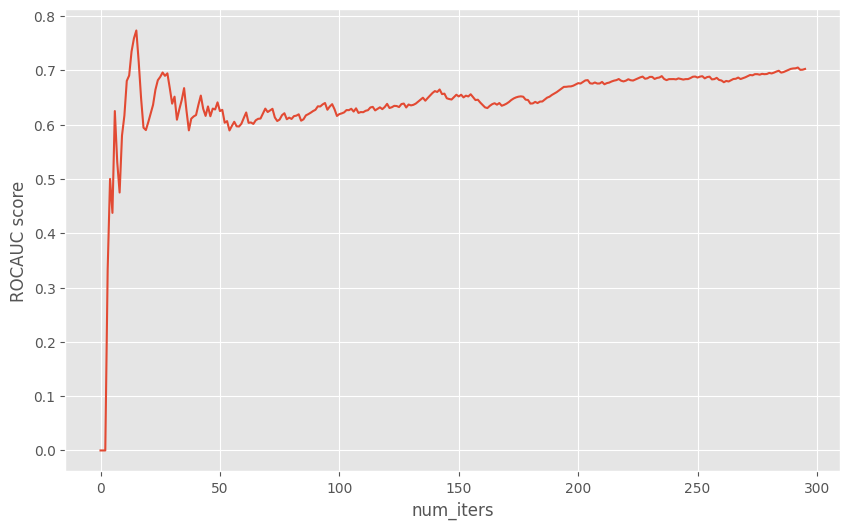

/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ROC AUC After Test Set learning: ROCAUC: 72.57%
Confusion Matrix
    0     1    
0   125    78  
1    63   158  
------------------------------


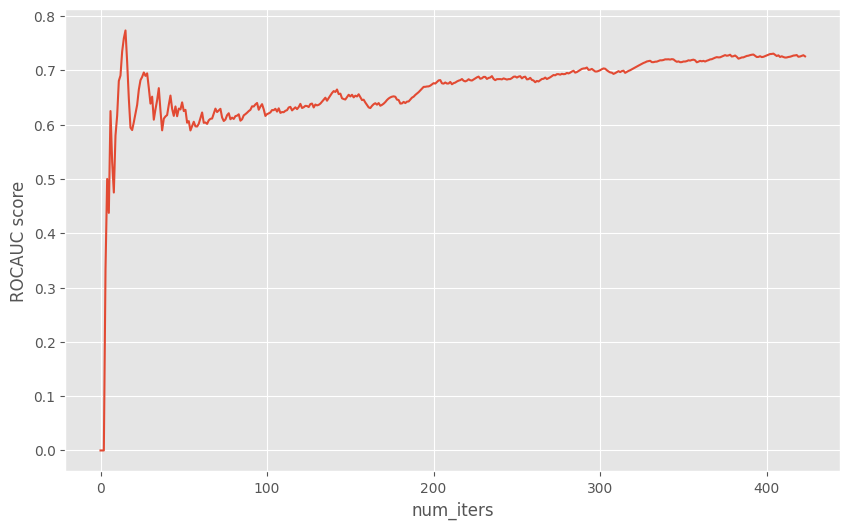

In [5]:
online_model.train_online_model()

### The Recommended Tweets accoring to the Acceptence probability are recorded in the online_model.recommended attribute. The OnlineTraining class built for this use case outputs a list of the highest ranked tweets. By default, the list only outputs 20 recommended tweets, but it can be configured as a class parameter

In [6]:
online_model.recommended

{734698: 0.9936023009581563,
 520034: 0.9928920988253802,
 922885: 0.9876989348946189,
 967814: 0.9874044456220896,
 893149: 0.9873594850248185,
 137050: 0.9865898012641758,
 570562: 0.9852716849409932,
 347695: 0.9787797669901322,
 458560: 0.9711190199615457,
 239059: 0.9705981654361743,
 239502: 0.9626283767976221,
 414029: 0.9620697882317893,
 584236: 0.9608678596838015,
 920871: 0.9603595430880795,
 763775: 0.9560400023979417,
 119266: 0.9559424845206642,
 741382: 0.9507237300035757,
 902854: 0.9502263688336252,
 992802: 0.9492307912806381,
 918900: 0.948556138770166}

In [7]:
# We save the Reco at Train to see how it evolves in the future
reco_at_train = deepcopy(online_model.recommended)

# Simulating User input

With the model trained and a successful evaluation performed we can do a simple simulated exercise in which we will recreate a user experience in the app. 

The logic is simple, a tweet is presented, the reaction recorded (accepted or rejected), the model re-trained and the recommendations reformulated.

In [8]:
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,query_8,reading_ease,reading_time,label
0,0.038100,0.050738,0.007135,0.043838,0.019197,0.097106,-0.103237,0.019851,-0.007644,-0.018441,...,0.009451,0.045204,0.115512,-0.072247,0.028232,-0.023187,True,0.0617,0.08500,accepted
1,-0.033662,0.088740,0.002582,-0.009213,-0.019243,0.032072,-0.128135,0.143166,-0.011542,0.002317,...,-0.051115,0.055875,-0.026965,0.007462,0.126122,-0.017651,True,0.1801,0.12625,accepted
2,-0.028376,-0.025853,-0.011038,0.076334,0.068841,0.074753,-0.183110,0.012640,-0.061551,-0.030909,...,0.083589,0.018917,0.033408,-0.054598,0.118340,-0.004003,True,0.4035,0.14500,accepted
3,-0.009656,-0.056961,-0.090229,0.039601,0.057927,-0.004521,-0.085766,0.048445,-0.012106,0.047991,...,-0.059702,-0.070059,-0.009153,0.001969,0.088698,-0.125449,True,0.3764,0.22750,rejected
4,-0.018768,-0.005484,-0.006060,0.060949,0.066479,0.079258,-0.053393,0.089731,-0.066677,0.003284,...,0.002020,-0.032499,0.074441,-0.060211,0.126635,-0.008543,True,0.3290,0.15250,rejected


In [9]:
# Let's see the first tweet in the dataset
sim_df.iloc[0].label

'accepted'

In [10]:
# pretend user interacted with the tweet
# and rejected the tweet 
# (in this case we a priori now this as the dataset is labelled)
# but the logic still remains, the weights are updated with the new stream
online_model._return_fake_user_input = 0  # 0 == rejection


Tweet ID 816807
{False: 0.28409023029378155, True: 0.7159097697062184}
ROC AUC After Test Set learning: ROCAUC: 72.44%
Confusion Matrix
    0     1    
0   125    79  
1    63   158  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


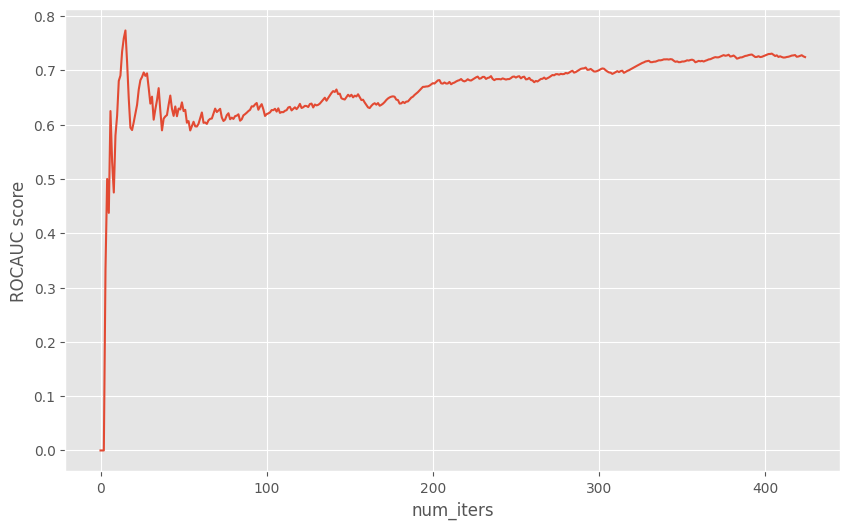

In [11]:
# Here the tweet is presented and the user input recorded
pred, _ = online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[0]
)

In this case, the model would have predicted an "rejected", The model is NOT correct!. The input is given, the model learns and the performance metrics updated. 

**Second Tweet Interaction**

In [12]:
# Here the user accepted the tweet
sim_df.iloc[1].label

'accepted'

Tweet ID 229126
{False: 0.26689822158195853, True: 0.7331017784180415}
ROC AUC After Test Set learning: ROCAUC: 72.48%
Confusion Matrix
    0     1    
0   125    79  
1    63   159  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


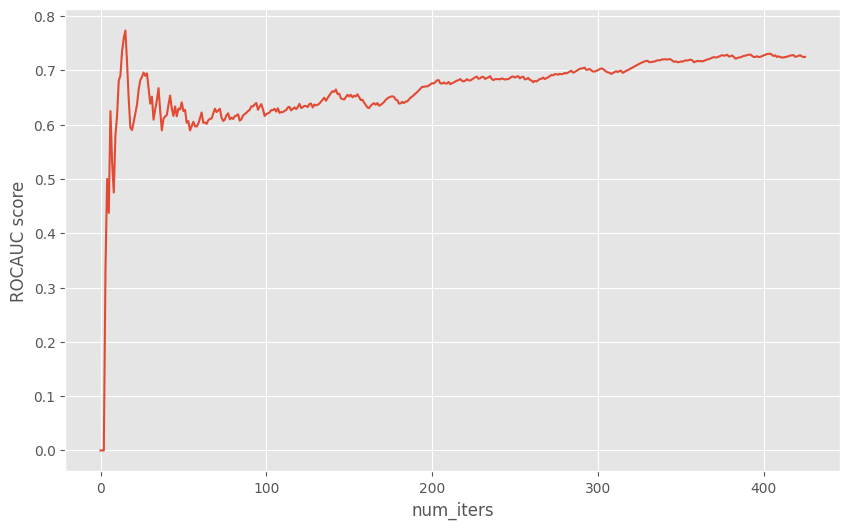

In [13]:
# the setter of the method allows us to set it as 1 or 0 smoothly
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet
# Again tweet is presented to the user, interaction updates the weights
# in this case, the model fails again
pred, _ = online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[1]
)

## We continue doing simulations with the same logic, updating the weights on the fly

In [14]:

sim_df.iloc[2].label

'accepted'

Tweet ID 851785
{False: 0.7524476271984261, True: 0.24755237280157394}
ROC AUC After Test Set learning: ROCAUC: 72.34%
Confusion Matrix
    0     1    
0   125    79  
1    64   159  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


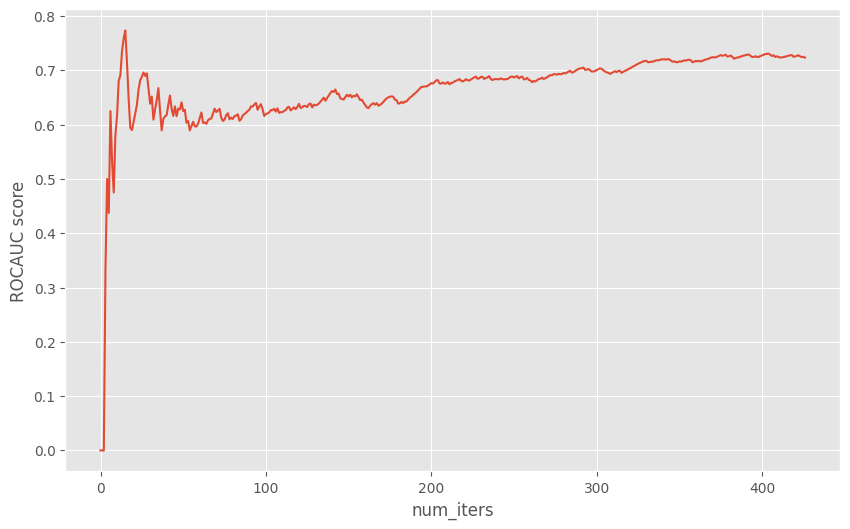

In [15]:
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet

pred, _ = online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[2]
)

In [16]:

sim_df.iloc[7].label

'rejected'

Tweet ID 365190
{False: 0.6073061868517081, True: 0.3926938131482919}
ROC AUC After Test Set learning: ROCAUC: 72.25%
Confusion Matrix
    0     1    
0   125    79  
1    65   159  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


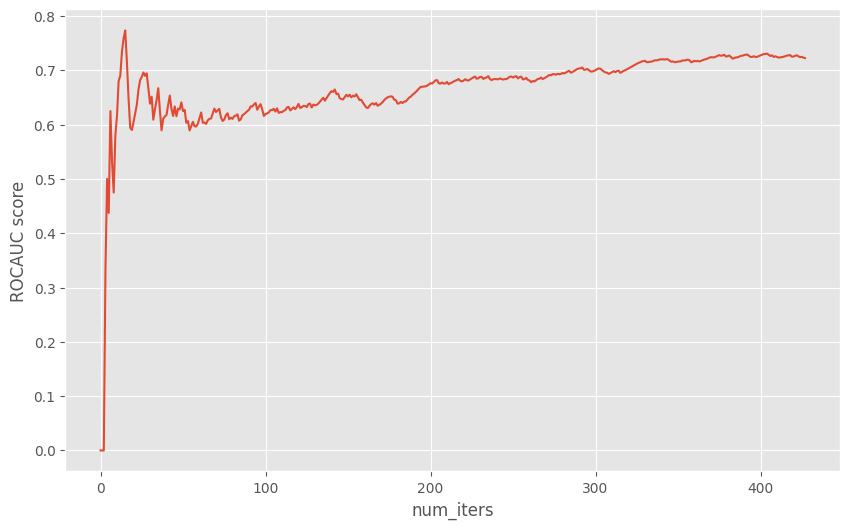

In [17]:
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet

pred, _ = online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[4]
)

## Working with very similar tweets

As a final simulation exercise, let's pretend we have a very similar set of tweets which have a high engagement interaction with the user. This would mimic a conversation or a topic in which the user is highly active, updating the recommendation and boosting these type of tweets higher and higher in the ranking

Tweet ID 662040
{False: 0.0, True: 1}
ROC AUC After Test Set learning: ROCAUC: 72.36%
Confusion Matrix
    0     1    
0   125    79  
1    65   160  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


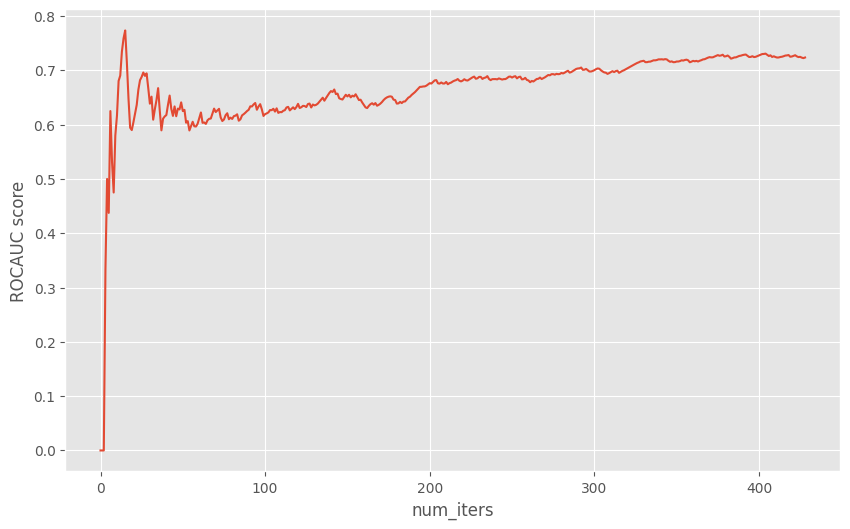

Tweet ID 801055
{False: 0.0004943979538688525, True: 0.9995056020461311}
ROC AUC After Test Set learning: ROCAUC: 72.48%
Confusion Matrix
    0     1    
0   125    79  
1    65   161  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


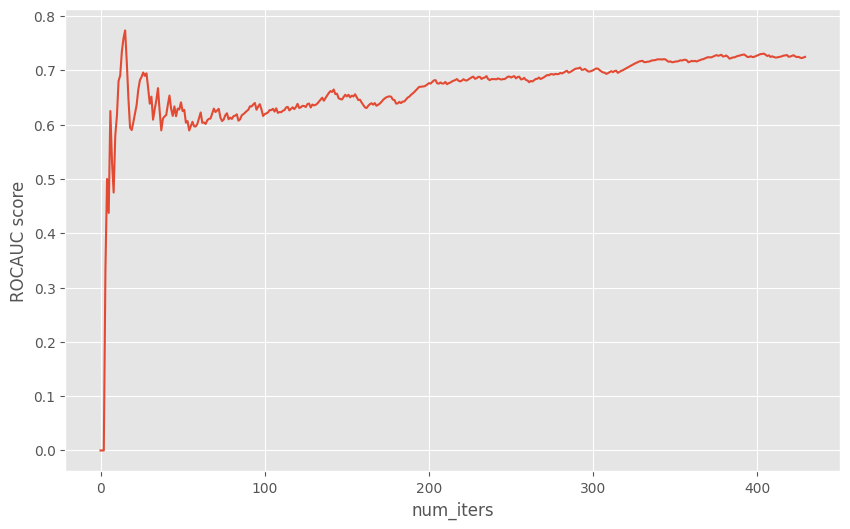

Tweet ID 799216
{False: 0.0021450322916511944, True: 0.9978549677083488}
ROC AUC After Test Set learning: ROCAUC: 72.59%
Confusion Matrix
    0     1    
0   125    79  
1    65   162  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


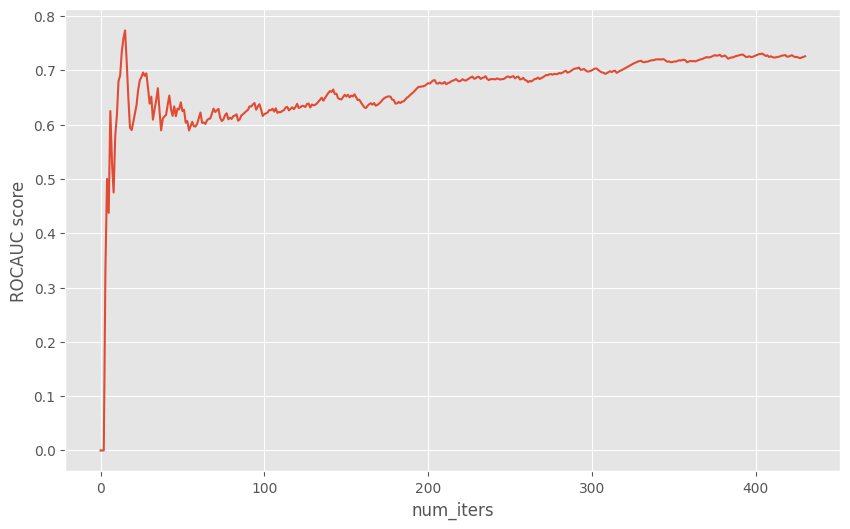

Tweet ID 624869
{False: 0.0037806859823990013, True: 0.996219314017601}
ROC AUC After Test Set learning: ROCAUC: 72.70%
Confusion Matrix
    0     1    
0   125    79  
1    65   163  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


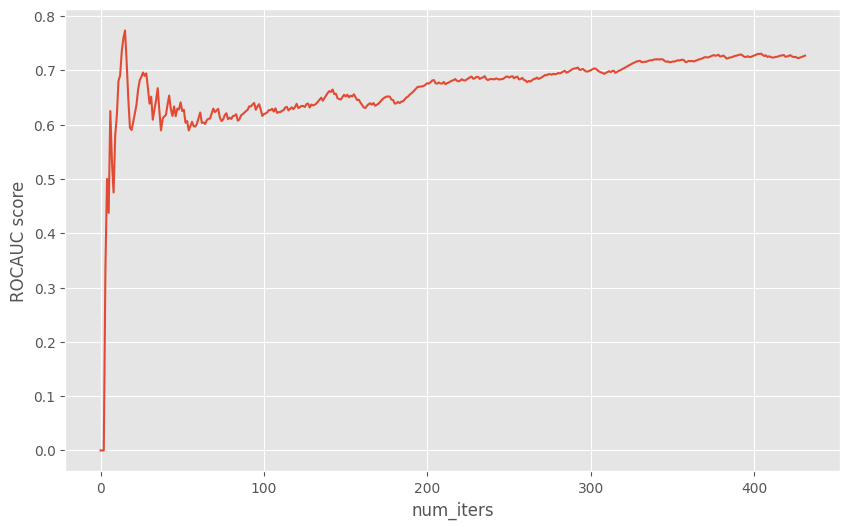

Tweet ID 477001
{False: 0.005094612238647933, True: 0.9949053877613521}
ROC AUC After Test Set learning: ROCAUC: 72.81%
Confusion Matrix
    0     1    
0   125    79  
1    65   164  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


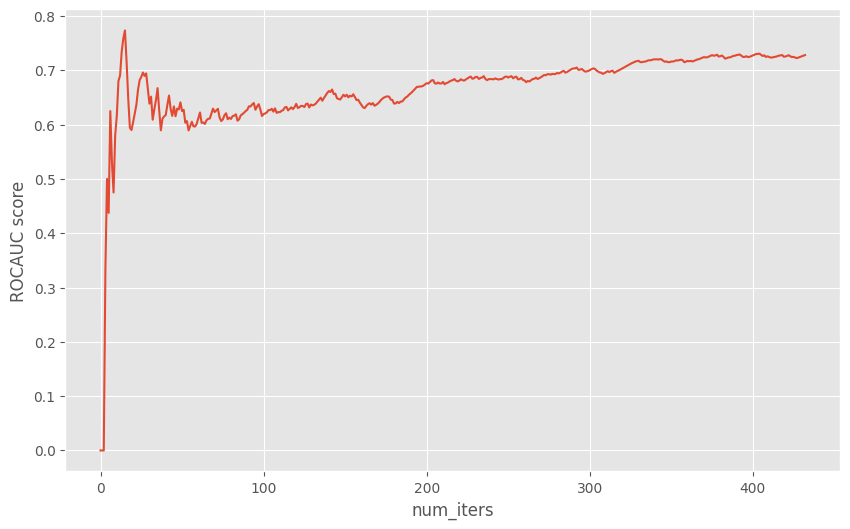

Tweet ID 556212
{False: 0.006098264223844518, True: 0.9939017357761555}
ROC AUC After Test Set learning: ROCAUC: 72.92%
Confusion Matrix
    0     1    
0   125    79  
1    65   165  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


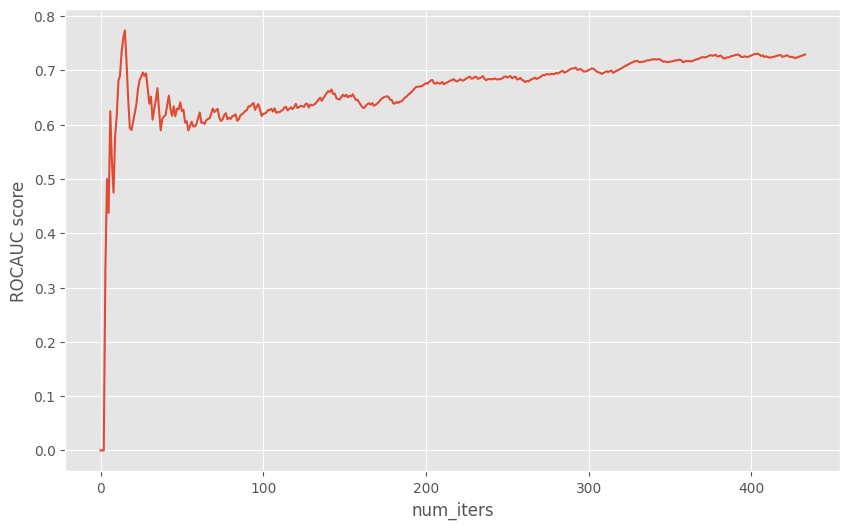

Tweet ID 147742
{False: 0.006853266100339317, True: 0.9931467338996607}
ROC AUC After Test Set learning: ROCAUC: 73.03%
Confusion Matrix
    0     1    
0   125    79  
1    65   166  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


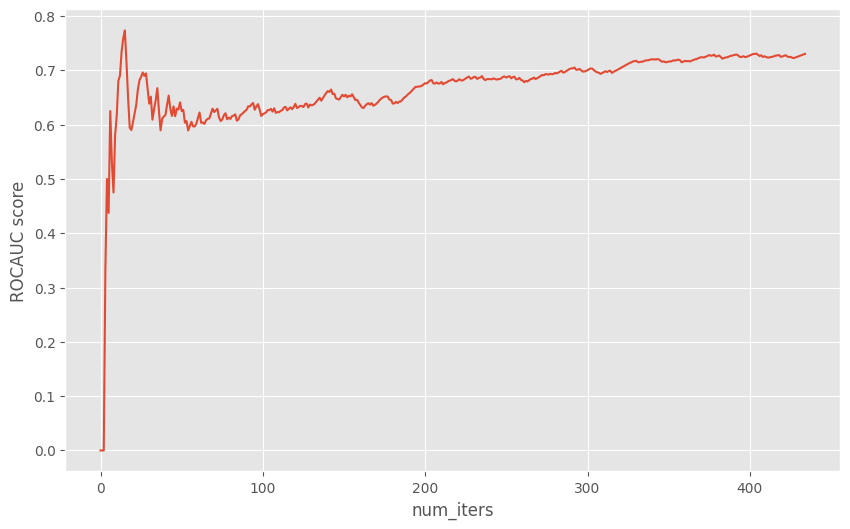

Tweet ID 877688
{False: 0.007417572687418494, True: 0.9925824273125815}
ROC AUC After Test Set learning: ROCAUC: 73.14%
Confusion Matrix
    0     1    
0   125    79  
1    65   167  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


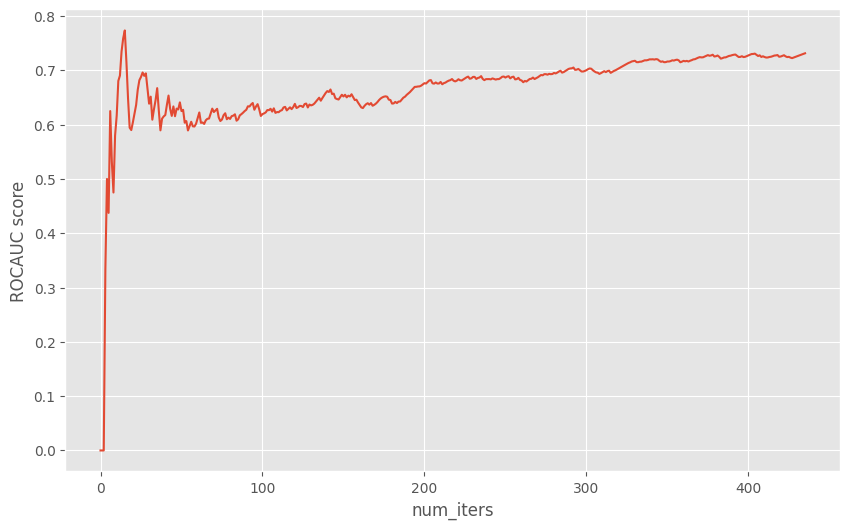

Tweet ID 184102
{False: 0.007836985069941571, True: 0.9921630149300584}
ROC AUC After Test Set learning: ROCAUC: 73.25%
Confusion Matrix
    0     1    
0   125    79  
1    65   168  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


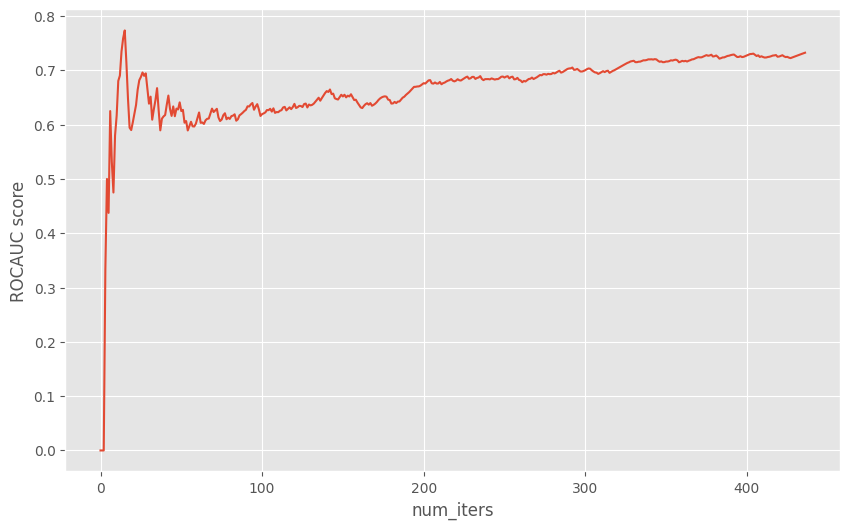

Tweet ID 115125
{False: 0.008146112075887113, True: 0.9918538879241129}
ROC AUC After Test Set learning: ROCAUC: 73.35%
Confusion Matrix
    0     1    
0   125    79  
1    65   169  
------------------------------


/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kdlx593/miniconda3/envs/stream_ml/lib/python3.12/site-packages/seaborn-0.12.2-py3.12.egg/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


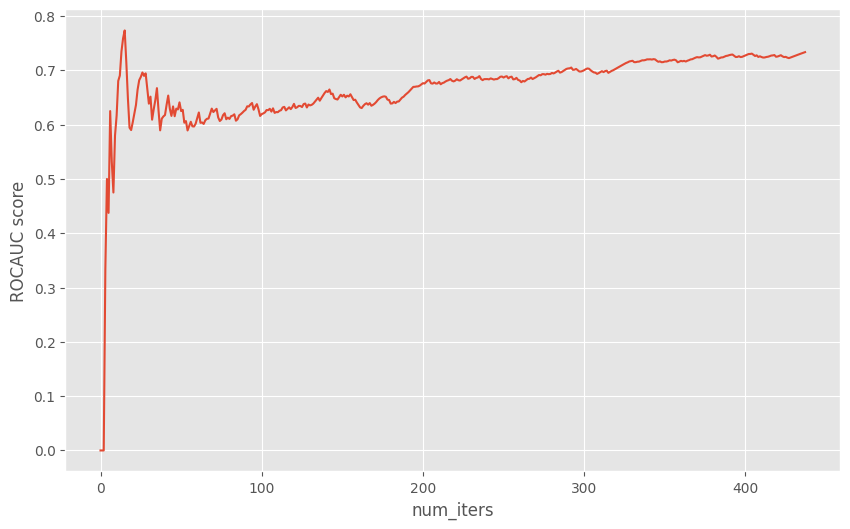

In [18]:
# Force a high interaction with very similar tweets
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet
similar_tweets = sim_df.drop('label', axis=1).iloc[4]
for i in range(10):  # we build 10 very similar, almost identical tweeets
    if 'tweet_id' in similar_tweets.keys():
        similar_tweets = similar_tweets.drop('tweet_id')
        
    similar_tweets += 0.0001 # slight change in all cols
    pred, _ = online_model.new_entry(
        similar_tweets  
    )


### Here it is fascinating to see that the probability of acceptance keeps on growing and growing for these type of tweets, as the user is constantly engaged by this particular conversation or topic. Finally, we can see that the recommended tweets dictionray has in fact been updated. 

In [19]:
import operator
sorted(
    online_model.recommended.items(),
    key=operator.itemgetter(1),
    reverse=True
)

[(662040, 1),
 (801055, 0.9995056020461311),
 (799216, 0.9978549677083488),
 (624869, 0.996219314017601),
 (477001, 0.9949053877613521),
 (556212, 0.9939017357761555),
 (734698, 0.9936023009581563),
 (147742, 0.9931467338996607),
 (520034, 0.9928920988253802),
 (877688, 0.9925824273125815),
 (184102, 0.9921630149300584),
 (115125, 0.9918538879241129),
 (922885, 0.9876989348946189),
 (967814, 0.9874044456220896),
 (893149, 0.9873594850248185),
 (137050, 0.9865898012641758),
 (570562, 0.9852716849409932),
 (347695, 0.9787797669901322),
 (458560, 0.9711190199615457),
 (239059, 0.9705981654361743),
 (239502, 0.9626283767976221),
 (414029, 0.9620697882317893),
 (584236, 0.9608678596838015),
 (920871, 0.9603595430880795),
 (763775, 0.9560400023979417),
 (119266, 0.9559424845206642),
 (741382, 0.9507237300035757),
 (902854, 0.9502263688336252),
 (992802, 0.9492307912806381),
 (918900, 0.948556138770166)]

In [20]:
online_model.recommended.keys() - reco_at_train.keys()

{115125,
 147742,
 184102,
 477001,
 556212,
 624869,
 662040,
 799216,
 801055,
 877688}

# Save the Model

In [21]:
online_model.save_model_pipeline("../models/online_model_1.pkl")

Model Pipeline saved at ../models/online_model_1.pkl


In [22]:
# save the model then
# reaload the model and use
import pickle

saving_path = "../models/online_model_1.pkl"

with open(saving_path, "wb") as f: 
    pickle.dump(online_model, f)



In [23]:
with open(saving_path, "rb") as f:
    reloaded_model = pickle.load(f)

print(reloaded_model._metric)
print()
print("confusion matrix")
print()
print(reloaded_model._confusion_matrix)

ROCAUC: 73.35%

confusion matrix

    0     1    
0   125    79  
1    65   169  


End of file